In [1]:
import numpy as np

import matplotlib.pyplot as plt

import rydcalc
import tqdm

import scipy.constants as cs

### Atoms and states

Atoms are classes, and you need to instantiate them to perform computations. The classes can cache data, so you should only instantiate one instance of each atom type per notebook. The case for creating two instances would be if you want to change the properties of one of them, ie, the quantum defects.

States are objects that are created with atom.get_state().

The quantum numbers used vary according to the atomic species.

States are fully-fleshed out objects that support equality testing (st1==st2), and the creation fails gracefully by returning None if the requested quantum numbers are invalid.

In [2]:
# Define a few atoms to play with

H = rydcalc.Hydrogen()
Rb = rydcalc.Rubidium87(cpp_numerov=True,use_db=False)
Cs = rydcalc.Cesium133(cpp_numerov=True,use_db=False)

st = Rb.get_state((25,0,1/2,1/2))

In [3]:
# Hydrogen: nlm quantum numbers
# Note that for consistency across all atoms and QDT/MQDT states are internally represented with 'npfm' quantum numbers (n, parity, f and mF)
# 'nlm' is converted to this by ignoring electron spin (s=0), and putting the l into the MQDT channel
st_h = H.get_state((50,49,49),tt='nlm')
print(st_h,st_h.atom)
print(st_h.channels)

# Alkali: nljm quantum numbers -- S=1/2 implicitly
st_rb = Rb.get_state((75,0,1/2,1/2),tt='nljm')
print(st_rb,st_rb.atom)
print(st_rb.channels)

# If you ask for a state with bad quantum numbers, None is returned
st_h2 = H.get_state((50,51,51))
print(st_h2)

|H:50,49,49> <rydcalc.hydrogen.Hydrogen object at 0x72bdb20e3dd0>
[Channel, t=slj, qn=(0, 49, 49), core: p]
|Rb:75,S,0.5,0.5> <rydcalc.alkali_data.Rubidium87 object at 0x72bdb20e3e10>
[Channel, t=slj, qn=(0.5, 0, 0.5), core: Kr+]
None


Text(0.5, 0, '$n$')

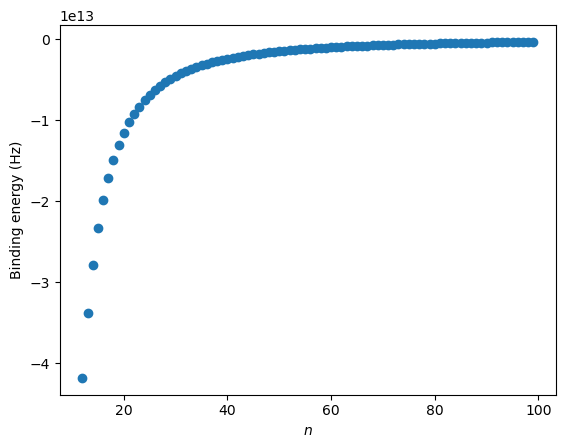

In [4]:
# Make a plot of the energy of the states in a given series

nn_list = range(12,100)
en_list = [Rb.get_state((nn,0,1/2,1/2)).get_energy_Hz() for nn in nn_list]

plt.plot(nn_list,np.array(en_list),'o')
plt.ylabel("Binding energy (Hz)")
plt.xlabel(r"$n$")

### Computing matrix elements

Each atom has a function

    atom.get_multipole_me(st1,st2,k)

that computes the matrix element of r^k between the given states, returning the answer in atomic units of (e a_0)^k.

In [5]:
st_rb = Rb.get_state((75,0,1/2,1/2))
st_rb1 = Rb.get_state((75,1,1/2,1/2))
st_rb2 = Rb.get_state((75,2,3/2,3/2))

# get the energy in atomic units
en=st_rb.get_energy_au()

# get the Lande g-factor
g = st_rb.get_g()
print("g=%.4f" % g)

# compute the matrix elements between states (k=1 and k=2)
# units are atomic units: e*a_0**k
dip_me = Rb.get_multipole_me(st_rb,st_rb1,1)
quad_me = Rb.get_multipole_me(st_rb,st_rb2,2)

print(dip_me,quad_me)

g=2.0023
1986.1537125286807 -884006.3061287752


### Computing lifetimes

We can calculate the partial decay rate between two states, or the total decay rate of a state. Both require a specification of the temperature, which is done using an "environment" object.

Note that this can take a relatively long time to run the first time if there is no database, but will speed up considerably on subsequent iterations because the wavefunctions are cached in the state objects.

To illustrate this, we compute the lifetime for one state, then compute the lifetime for a range of states at two different temperatures. The longer calculation goes much faster than the initial calculation.

In [6]:
st_rb = Rb.get_state((75,0,1/2,1/2))
st_rb1 = Rb.get_state((75,1,1/2,1/2))

env = rydcalc.environment(T_K=300)

# partial decay rate
partial_tau = Rb.partial_decay(st_rb,st_rb1,env)

# total decay rate (lifetime)
tau = 1/Rb.total_decay(st_rb,env)

print('Lifetime: %.2e s'%tau)

Lifetime: 1.77e-04 s


In [7]:
# even without a database, this should be considerably faster than the previous calculation because many states are reused.

lifetimes = []

for n in tqdm.tqdm(range(50,100,2)):
    st_rb = Rb.get_state((n,0,1/2,1/2),tt='nljm')

    for t_k in [0,300]:
        env = rydcalc.environment(T_K=t_k)
        tau = 1/Rb.total_decay(st_rb,env)

        lifetimes.append({'n':n,'T_K':t_k,'tau':tau})


100%|███████████████████████████████████████████| 25/25 [00:25<00:00,  1.02s/it]


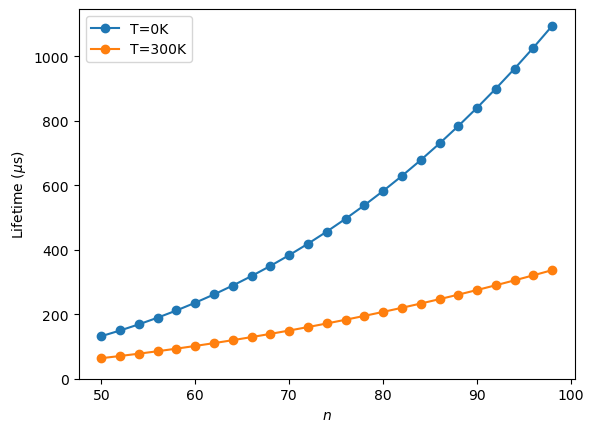

In [8]:
plt.plot([l['n'] for l in lifetimes if l['T_K']==0],[1e6*l['tau'] for l in lifetimes if l['T_K']==0],'o-',label='T=0K')
plt.plot([l['n'] for l in lifetimes if l['T_K']==300],[1e6*l['tau'] for l in lifetimes if l['T_K']==300],'o-',label='T=300K')

plt.xlabel(r'$n$')
plt.ylabel(r'Lifetime ($\mu$s)')
plt.ylim(ymin=0)
plt.legend();

### Stark shifts

To compute something more complicated like the Stark map, we need to construct a basis of states and diagnoalize the Hamiltonian.

Rydcalc provides helper classes for this: 'single_basis' and 'pair_basis' for one- and two-atom basis states. Additioanlly, the module rydcalc.analysis provides some wrapper functions that perform complete calculations and plot the results, which are helpful examples of how to use the underlying routines. Note that these are not full-featured analysis functions and the fitting routines will produce bad answers if the spacing of the field points is not chosen appropriately. Be cautious with the results if you have not inspected the fit by eye!

Here, we compute the Stark map for a Rb state

Done computing matrix elements, basis size= 308
Stark shift = -7.372e+02 MHz/(V/cm)^2


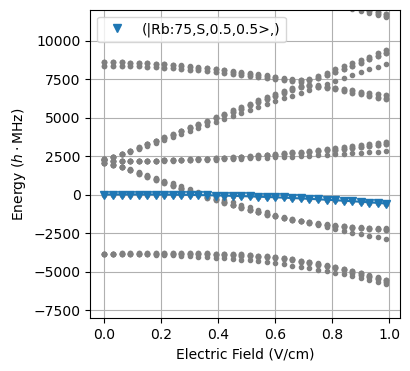

In [9]:
st_rb = Rb.get_state((75,0,1/2,1/2),tt='nljm')
#st_rb = H.get_state((75,0,0))

opts = {'dn': 5,'dl': 5,'dm': 1,'dipole_allowed': False}

stark = rydcalc.analysis_stark(st_rb, include_opts = opts)

print("Done computing matrix elements, basis size=", stark.sb.dim())

res = stark.run(Ez_list_Vcm=np.arange(0,1,0.03))

stark.plot_stark_map(energy_range_Hz=4e9*np.array([-2,3]))

print("Stark shift = %.3e MHz/(V/cm)^2"%(1e-6*res[0][1]))

In [10]:
# now compute for a range of n and plot the results
n_list = np.arange(50,80,2)

res_stark = []

for nn in tqdm.tqdm(n_list):
    st_rb = Rb.get_state((nn,0,1/2,1/2),tt='nljm')

    stark = rydcalc.analysis_stark(st_rb,include_opts={'dn': 4, 'dl': 1, 'dm': 1})
    res = stark.run(Ez_list_Vcm=np.arange(0,0.01,0.003))

    res_stark.append({'n':nn,'res':res})


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 10.19it/s]


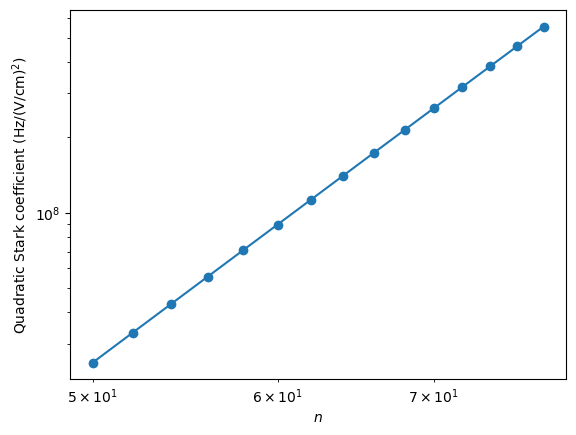

In [11]:
plt.plot([r['n'] for r in res_stark],[np.abs(r['res'][0][1]) for r in res_stark],'o-')

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$n$')
plt.ylabel(r'Quadratic Stark coefficient (Hz/(V/cm)$^2$)');

### Interactions

rydcalc.analysis also provides a fuction to construct and diagonalize a pair basis of states

In [12]:
st_rb = Rb.get_state((70,0,1/2,1/2))

# We can specify which other states are included in the basis
# The arguments are passed to pair_basis.fill, and in turn single_basis.fill
# In addition to specifying a range of n, l, m, you can also specify an arbitrary function to be evaluated for each candidate pair
opts = {'dn': 3,'dl': 3,'dm': 1,'dipole_allowed': False, 'pair_include_fn': lambda p0,p: np.abs(p0.energy_Hz-p.energy_Hz)<5e9}

pair_int = rydcalc.analysis_pair_interaction(st_rb,include_opts = opts)

print("Done computing matrix elements, basis size=", pair_int.pb.dim())

Basis size: 864
Done computing matrix elements, basis size= 864


In [13]:
rList_um = np.arange(20,30,1)
[c6d,c6e,c3d,c3e] = pair_int.run(rList_um=rList_um)
print(f"Asymptotic c6 coefficient = {c6d:.3e} Hz*um^6")

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 13.43it/s]

Asymptotic c6 coefficient = 8.847e+11 Hz*um^6


In [14]:
rList_um = np.arange(1.5,10,0.25)
pair_int.run(rList_um=rList_um, th=np.pi/2)

100%|███████████████████████████████████████████| 34/34 [00:02<00:00, 15.81it/s]


array([3.51188413e+10, 0.00000000e+00, 2.49449084e+10, 0.00000000e+00])

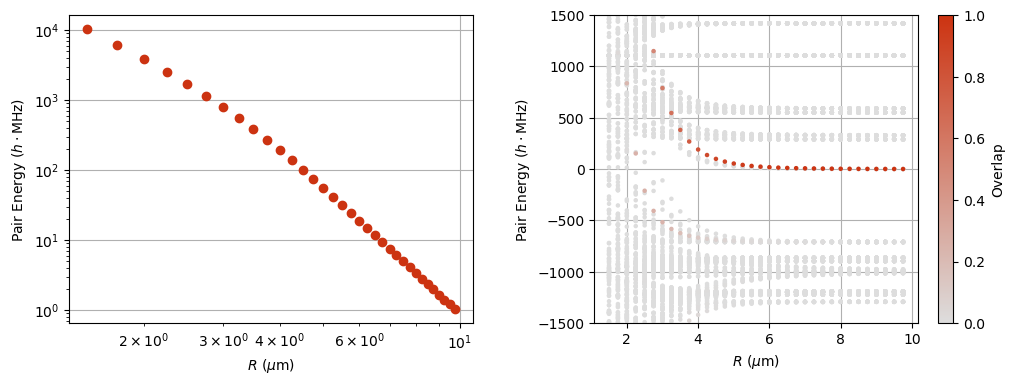

In [15]:
fig,axs = pair_int.pa_plot()
axs[1].set_ylim([-1500,1500]);

### Interspecies interactions


Interactions between different atomic species can be performed with no additional effort, by passing two state objects belonging to different atoms. Here, we compute the Rb-Cs Forster resonance from 2401.10325

In [16]:
st_rb = Rb.get_state((68,0,1/2,1/2))
st_cs = Cs.get_state((67,0,1/2,1/2))

# Since we are interested in long-range behavior near a Forster resonance, we can set the pair state energy range very small for a quick approximation
opts = {'dn': 3,'dl': 2,'dm': 1,'dipole_allowed': False, 'pair_include_fn': lambda p,p0: np.abs(p0.energy_Hz-p.energy_Hz)<1e9}

pair_int = rydcalc.analysis_pair_interaction(st_rb,st_cs,include_opts = opts)

print("Done computing matrix elements, basis size=", pair_int.pb.dim())

Basis size: 148
Done computing matrix elements, basis size= 148


In [17]:
rList_um = np.arange(5,10,0.1)
pair_int.run(rList_um=rList_um, th=0*np.pi/2, Bz_Gauss=6.65)

100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 329.66it/s]


array([-3.32374314e+12,  0.00000000e+00,  1.48603719e+10,  0.00000000e+00])

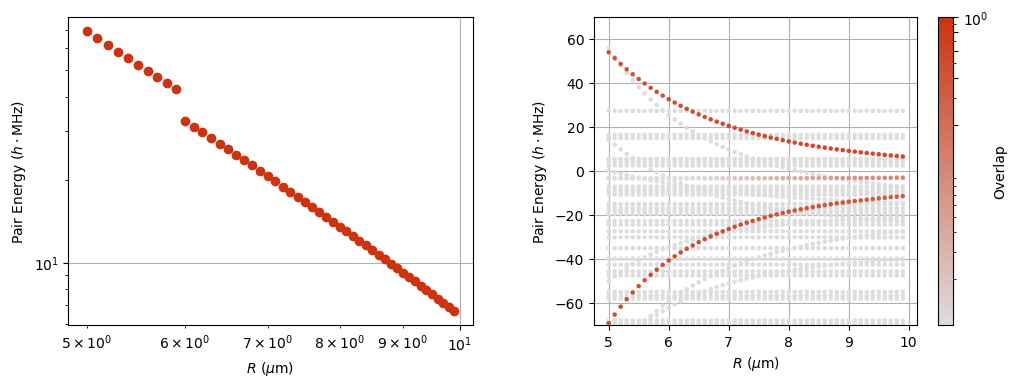

In [18]:
fig,axs = pair_int.pa_plot(include_plot_opts = {'ov_norm': 'log', 'log_norm': [0.01,1]})
axs[1].set_ylim([-70,70]);

## Alkaline earth atoms

All of the same functions apply to alkaline earth atoms. The only difference is in how the initial states are specified. As discussed in 2406.01482, the numbering of Rydberg states is sometimes ambiguous, so we instead abandon integer quantum numbers entirely and refer to states by their fractional quantum defects. Therefore, when you want to get a state, you ask for one near a certain fractional quantum defect, and it returns the closest MQDT bound state.

In [19]:
Yb174 = rydcalc.Ytterbium174(cpp_numerov=True,use_db=False)

In [20]:
yb174_st = Yb174.get_state((54,0,0,0))
print(yb174_st)

|174Yb:53.72,L=0,F=0.0,0.0>


In [21]:
yb174_st.get_g()

0

### Single-atom properties

With the MQDT model, some of the single-atom properites are more non-trivial. Here we give a few examples

In [22]:
# First, make a list of all the MQDT bound states and plot their quantum defects in a Lu-Fano type plot.
# To be sure we find all the states exactly once, we search over steps of 0.2 in nu, and keep track of which ones we have already seen

n_list = np.arange(20,100,0.2)
l_list = [0,1]
j_list = [0,1,2]

res = []
found_nu = {j: [] for j in j_list}

for nn in n_list:
    for ll in l_list:
        for jj in j_list:
            st = Yb174.get_state((nn,ll,jj,0))
            if st is not None:
                if st.v in found_nu[jj]:
                    continue
                found_nu[jj].append(st.v)

                res.append({'st': st, 'v': st.v, 'j': jj, 'l': ll, 'nu_exact': st.v_exact})

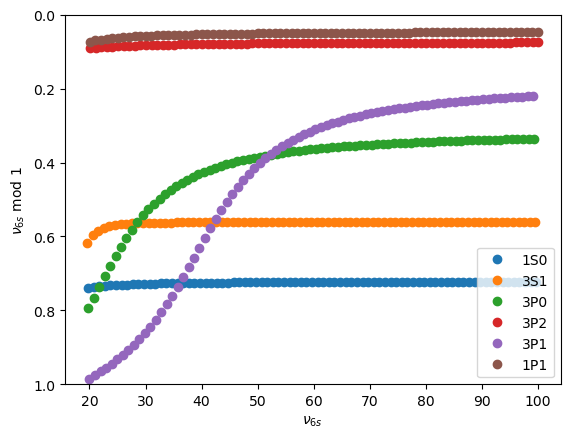

In [23]:
def is_triplet(st):
    # Figure out if the given state is primarily triplet or singlet, by looking at the MQDT channel coefficients in the LS basis
    return np.abs(st.Aalpha[0])**2 < np.abs(st.Aalpha[1])**2

plt.plot([r['v'] for r in res if r['l'] == 0 and r['j'] == 0],[np.mod(r['nu_exact'],1) for r in res if r['l'] == 0 and r['j'] == 0],'o',label='1S0')
plt.plot([r['v'] for r in res if r['l'] == 0 and r['j'] == 1],[np.mod(r['nu_exact'],1) for r in res if r['l'] == 0 and r['j'] == 1],'o',label='3S1')
plt.plot([r['v'] for r in res if r['l'] == 1 and r['j'] == 0],[np.mod(r['nu_exact'],1) for r in res if r['l'] == 1 and r['j'] == 0],'o',label='3P0')
plt.plot([r['v'] for r in res if r['l'] == 1 and r['j'] == 2],[np.mod(r['nu_exact'],1) for r in res if r['l'] == 1 and r['j'] == 2],'o',label='3P2')

plt.plot([r['v'] for r in res if r['l'] == 1 and r['j'] == 1 and is_triplet(r['st'])],[np.mod(r['nu_exact'],1) for r in res if r['l'] == 1 and r['j'] == 1 and is_triplet(r['st'])],'o',label='3P1')
plt.plot([r['v'] for r in res if r['l'] == 1 and r['j'] == 1 and not is_triplet(r['st'])],[np.mod(r['nu_exact'],1) for r in res if r['l'] == 1 and r['j'] == 1 and not is_triplet(r['st'])],'o',label='1P1')

plt.ylim([1,0])
plt.xlabel(r'$\nu_{6s}$')
plt.ylabel(r'$\nu_{6s}$ mod 1')
plt.legend()

In [24]:
# g-factor of the 1P1/3p1 series.
# Note that this is just provided to show how to extract these quantities from the MQDT model, but the magnetic moments for 174Yb have not been experimentally validated and do not include contributions from perturbing channels.

n_list = np.arange(20,100,0.2)
found_nu = []
res = []

for nn in n_list:
    st = Yb174.get_state((nn,1,1,1))
    if st.v in found_nu:
        continue
    found_nu.append(st.v)
    g = st.get_g()
    res.append({'v': st.v, 'g': g, 'st': st})

Text(100, 0.99, '$^1P_1$')

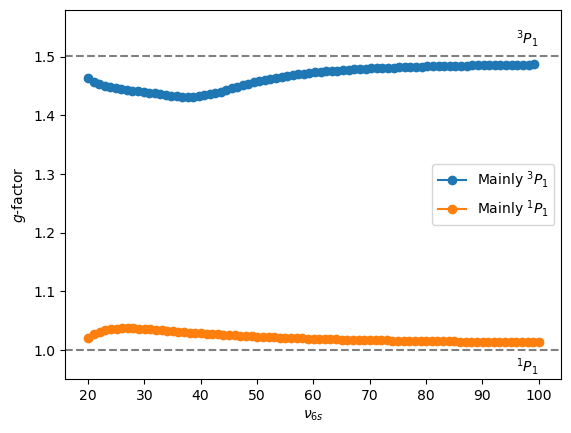

In [25]:
def is_triplet(st):
    # Figure out if the given state is primarily triplet or singlet, by looking at the MQDT channel coefficients in the LS basis
    return np.abs(st.Aalpha[0])**2 < np.abs(st.Aalpha[1])**2

plt.plot([r['v'] for r in res if is_triplet(r['st'])],[r['g'] for r in res if is_triplet(r['st'])],'o-',label='Mainly $^3P_1$')
plt.plot([r['v'] for r in res if not is_triplet(r['st'])],[r['g'] for r in res if not is_triplet(r['st'])],'o-',label='Mainly $^1P_1$')

plt.xlabel(r'$\nu_{6s}$')
plt.ylabel(r'$g$-factor')
plt.ylim(0.95,1.58)
plt.legend()

plt.axhline(y=1.50115965218128,linestyle = '--',color = 'gray')
plt.text(100, 1.55, r'$^3P_1$', color='k', ha='right', va='top')
plt.axhline(y=1,linestyle = '--',color = 'gray')
plt.text(100, 0.99, r'$^1P_1$', color='k', ha='right', va='top')

### Stark map for $^{174}$Yb

We compute this for the $\nu\approx37$ $^1$S$_0$ state, which has an anomalous sign stark shift because of a near-degeneracy with a nearby $^1$P$_1$ state (Fig. 1c of 2406.01482)

In [26]:
st_yb = Yb174.get_state((37,0,0,0))

opts = {'dn': 3,'dl': 2,'dm': 0,'dipole_allowed': False}

stark = rydcalc.analysis_stark(st_yb, include_opts = opts)

print("Done computing matrix elements, basis size=", stark.sb.dim())

res = stark.run(Ez_list_Vcm=np.arange(0,1,0.03))


Done computing matrix elements, basis size= 61


Text(0.5, 1.0, 'Stark shift = 3.011e+01 MHz/(V/cm)$^2$')

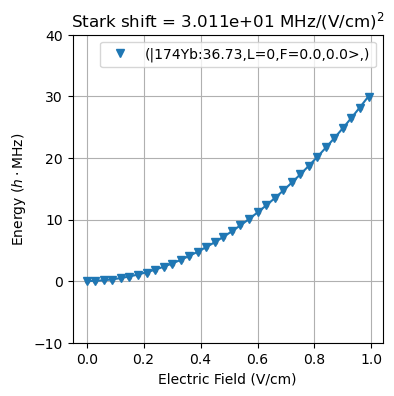

In [27]:
fig,ax = stark.plot_stark_map()

ax.set_ylim([-10,40])
ax.set_title("Stark shift = %.3e MHz/(V/cm)$^2$"%(1e-6*res[0][1]))

### Pair interaction for $^{174}$Yb

Compute the pair potential for the $n=50$ $^3$S$_1$ state in $^{174}$Yb.

An experimental value (with large uncertainty) was reported in Ma et al, PHYS. REV. X 12, 021028 (2022) of |C6| = 15(8) GHz*um^6

In [28]:
st_rb = Yb174.get_state((50-4.438,0,1,1))

# Note that the range of pair states here is smaller than is reasonable for good accuracy, to speed up calculation for tutorial.
opts = {'dn': 3,'dl': 2,'dm': 2,'dipole_allowed': False, 'pair_include_fn': lambda p,p0: np.abs(p0.energy_Hz-p.energy_Hz)<2e9}

pair_int = rydcalc.analysis_pair_interaction(st_rb,include_opts = opts)

print("Done computing matrix elements, basis size=", pair_int.pb.dim())

Basis size: 543
Done computing matrix elements, basis size= 543


In [29]:
rList_um = np.arange(20,30,1)
[c6d,c6e,c3d,c3e] = pair_int.run(rList_um=rList_um)
print(f"Asymptotic c6 coefficient = {c6d:.3e} Hz*um^6")

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 30.55it/s]

Asymptotic c6 coefficient = -1.432e+10 Hz*um^6


In [30]:
rList_um = np.arange(1.5,10,0.25)
pair_int.run(rList_um=rList_um, th=0*np.pi/2)

100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 42.70it/s]


array([-2.21896613e+09,  0.00000000e+00, -2.68990079e+08,  0.00000000e+00])

(-150.0, 150.0)

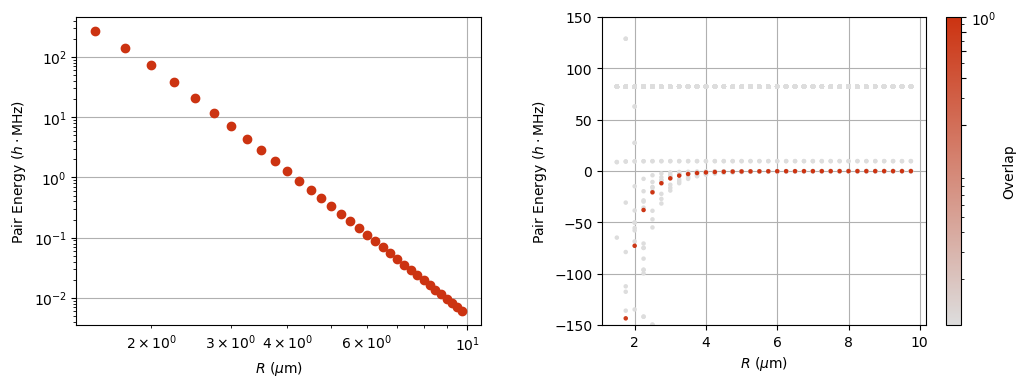

In [31]:
fig,axs = pair_int.pa_plot(include_plot_opts={'ov_norm': 'log', 'log_norm': [0.01,1]})
axs[1].set_ylim([-150,150])

## $^{171}$Yb

$^{171}$Yb calculations are the most complicated, as the hyperfine structure results in a large number of states. However, the calculations can be set up using the same functions as shown above for $^{174}$Yb.

In [2]:
Yb171 = rydcalc.Ytterbium171(cpp_numerov=True,use_db=False)

In [3]:
st_yb = Yb171.get_state((37,0,1/2,1/2))
st_yb

|171Yb:36.71,L=0,F=0.5,0.5>

In [34]:
# First, make a list of all the MQDT bound states and plot their quantum defects in a Lu-Fano type plot.
# To be sure we find all the states exactly once, we search over steps of 0.2 in nu, and keep track of which ones we have already seen, alternatively one can use the boundstatesinrange function from MQDTclass

n_list = np.arange(20,100,0.2)
l_list = [0,1]
f_list = [1/2,3/2,5/2]

res = []
found_nu = {f: [] for f in f_list}

for nn in n_list:
    for ll in l_list:
        for ff in f_list:
            st = Yb171.get_state((nn,ll,ff,1/2))
            if st is not None:
                if st.v in found_nu[ff]:
                    continue
                found_nu[ff].append(st.v)

                g = st.get_g()

                res.append({'st': st, 'v': st.v, 'f': ff, 'l': ll, 'g': g, 'nu_exact': st.v_exact})

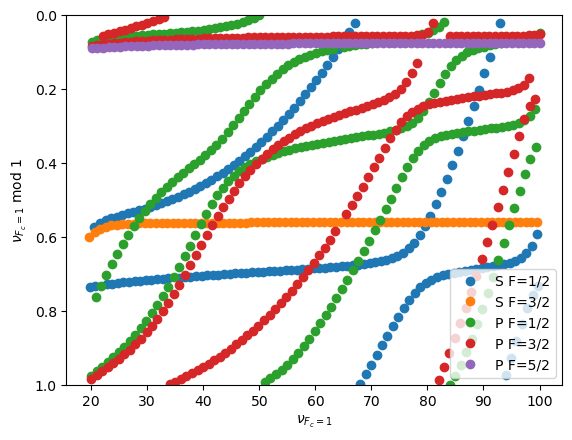

In [35]:
colormap = [
    {'l': 0, 'f': 1/2, 'label': 'S F=1/2'},
    {'l': 0, 'f': 3/2, 'label': 'S F=3/2'},
    {'l': 1, 'f': 1/2, 'label': 'P F=1/2'},
    {'l': 1, 'f': 3/2, 'label': 'P F=3/2'},
    {'l': 1, 'f': 5/2, 'label': 'P F=5/2'}
]

for c in colormap:
    plt.plot([r['nu_exact'] for r in res if r['l'] == c['l'] and r['f'] == c['f']],[np.mod(r['nu_exact'],1) for r in res if r['l'] == c['l'] and r['f'] == c['f']],'o',label=c['label'])

plt.ylim([1,0])
plt.xlabel(r'$\nu_{F_c=1}$')
plt.ylabel(r'$\nu_{F_c=1}$ mod 1')
plt.legend();

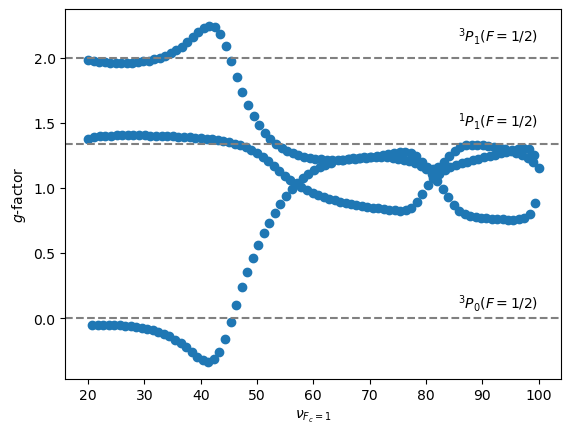

In [36]:
# Also plot magnetic moments.
c = {'l': 1, 'f': 1/2}

plt.plot([r['nu_exact'] for r in res if r['l'] == c['l'] and r['f'] == c['f']],[r['g'] for r in res if r['l'] == c['l'] and r['f'] == c['f']],'o')
plt.xlabel(r'$\nu_{F_c=1}$')
plt.ylabel(r'$g$-factor')


plt.axhline(y=0,linestyle = '--',color = 'gray')
plt.text(100, 0.2, r'$^3P_0(F=1/2)$', color='k', ha='right', va='top')
plt.axhline(y=1+1/3,linestyle = '--',color = 'gray')
plt.text(100, 1.6, r'$^1P_1(F=1/2)$', color='k', ha='right', va='top')
plt.axhline(y=2.0015462029083735,linestyle = '--',color = 'gray')
plt.text(100, 2.25, r'$^3P_1(F=1/2)$', color='k', ha='right', va='top');

### Stark map for $^{171}$Yb

Compute Stark map for the $\nu=64.09$ S F=1/2 state, which is reported in Peper et al. Because it is near a crossing with a P state, the Stark shift is non-quadradic even for very small fields.

In [37]:
st_yb = Yb171.get_state((64.09,0,1/2,1/2))

opts = {'dn': 3,'dl': 2,'dm': 0,'dipole_allowed': False}

stark = rydcalc.analysis_stark(st_yb, include_opts = opts)

print("Done computing matrix elements, basis size=", stark.sb.dim())

res = stark.run(Ez_list_Vcm=np.arange(-0.2,0.2,0.02))


Done computing matrix elements, basis size= 110


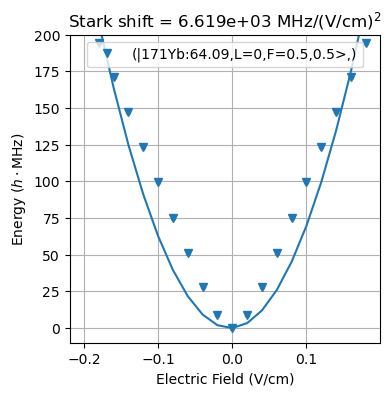

In [38]:
fig,ax = stark.plot_stark_map()

ax.set_ylim([-10,200])
ax.set_title("Stark shift = %.3e MHz/(V/cm)$^2$"%(1e-6*res[0][1]));

### Interactions for $^{171}$Yb

In [39]:
st_yb = Yb171.get_state((54.28,0,1/2,1/2))

# Note that the range of pair states here is smaller than is reasonable for good accuracy, to speed up calculation for tutorial.

includefn = lambda p,p0: np.abs(p0.energy_Hz-p.energy_Hz)<10e9
opts = {'dn': 2,'dl': 1,'dm': 1,'dipole_allowed': True, 'pair_include_fn': includefn}

pair_int = rydcalc.analysis_pair_interaction(st_yb,include_opts = opts)

print("Done computing matrix elements, basis size=", pair_int.pb.dim())

Basis size: 406
Done computing matrix elements, basis size= 406


In [40]:
rList_um = np.arange(20,30,1)
[c6d,c6e,c3d,c3e] = pair_int.run(rList_um=rList_um)
print(f"Asymptotic c6 coefficient = {c6d:.3e} Hz*um^6")

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 71.48it/s]

Asymptotic c6 coefficient = 3.441e+10 Hz*um^6


In [41]:
rList_um = np.arange(1.5,10,0.25)
pair_int.run(rList_um=rList_um, th=0*np.pi/2)

100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 81.17it/s]


array([8.41699443e+09, 0.00000000e+00, 1.30881774e+09, 0.00000000e+00])

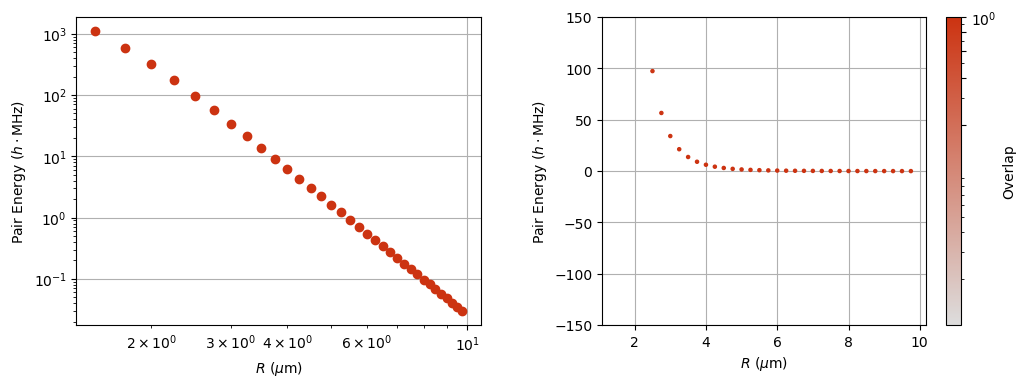

In [42]:
fig,axs = pair_int.pa_plot(include_plot_opts={'ov_norm': 'log', 'log_norm': [0.01,1]})
axs[1].set_ylim([-150,150]);

### Matrix elements to low-n states for $^{171}$Yb

Transition dipole matrix elements $Q_{r,6\,^3\mathrm{P}_0}^{(1q)}$ between the $6s6p$ $^3$P$_0$ ($m_F = +1/2$) metastable and Rydberg state $r$, where $r$ corresponds to $\nu$ S $F=3/2$ ($m_F=3/2$) (black) or $\nu$ S, $F=1/2$ ($m_F=-1/2$) (red and blue) Rydberg states

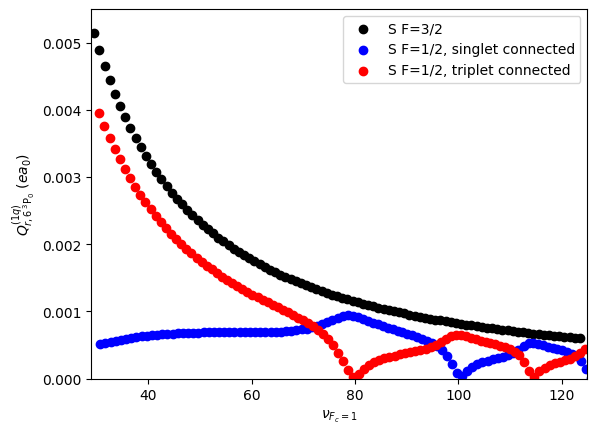

In [3]:
st3P0 = Yb171.get_state((6,1,1,0,1/2, 1/2),tt='NIST')

matrixelements_S_F32 = []
matrixelements_S_F12_S = []
matrixelements_S_F12_T = []

for i in np.arange(30,125):
    st_S_F32 = Yb171.get_state((i,0,3/2,+3/2))
    matrixelements_S_F32.append({"nu":st_S_F32.v_exact,"mat":Yb171.get_multipole_me(st3P0,st_S_F32)})


st_S_F12_singletconnected = Yb171.get_state((29.72,0,1/2,-1/2))
st_S_F12_tripletconnected = Yb171.get_state((29.52,0,1/2,-1/2))

for i in np.arange(0,100):
    st_S_F12_singletconnected  = Yb171.get_state((st_S_F12_singletconnected.v_exact+1,0,1/2,-1/2))
    st_S_F12_tripletconnected  = Yb171.get_state((st_S_F12_tripletconnected.v_exact+1,0,1/2,-1/2))
    
    matrixelements_S_F12_S.append({"nu":st_S_F12_singletconnected.v_exact,"mat":Yb171.get_multipole_me(st3P0,st_S_F12_singletconnected)})
    matrixelements_S_F12_T.append({"nu":st_S_F12_tripletconnected.v_exact,"mat":Yb171.get_multipole_me(st3P0,st_S_F12_tripletconnected)})

plt.scatter([r["nu"] for r in matrixelements_S_F32],[np.abs(r["mat"]) for r in matrixelements_S_F32],color='k',label = r'S F=3/2')
plt.scatter([r["nu"] for r in matrixelements_S_F12_S],[np.abs(r["mat"]) for r in matrixelements_S_F12_S],color = 'b',label = r'S F=1/2, singlet connected')
plt.scatter([r["nu"] for r in matrixelements_S_F12_T],[np.abs(r["mat"]) for r in matrixelements_S_F12_T],color = 'r',label = r'S F=1/2, triplet connected')

plt.xlabel(r"$\nu_{F_c=1}$")
plt.ylabel(r"$Q_{r,6\,^3\mathrm{P}_0}^{(1q)}$ ($ea_0$)")
plt.ylim([0,0.0055])
plt.xlim([29,125])
plt.legend();